In [21]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", 100)

# Load datasets

In [2]:
DATA_DIR = '../data/raw'
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

# Merge datasets by coordinates (time, longitude, latitude)

In [3]:
merged_dataset = xr.merge([ds[name][name] for name in ds.keys()])

# include a variable which tells if a grid is in socat location
# so that we can split a test set during the model training
merged_dataset = xr.merge([merged_dataset, ds['pCO2']['socat_mask']])

In [4]:
merged_dataset

<xarray.Dataset>
Dimensions:     (time: 421, xlon: 360, ylat: 180)
Coordinates:
  * xlon        (xlon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * ylat        (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time        (time) datetime64[ns] 1982-01-16T12:00:00 ... 2017-01-16T12:00:00
    TLONG       float64 ...
    TLAT        float64 ...
Data variables:
    pCO2        (time, ylat, xlon) float64 ...
    XCO2        (time) float32 ...
    SST         (time, ylat, xlon) float32 ...
    SSS         (time, ylat, xlon) float32 ...
    MLD         (time, ylat, xlon) float32 ...
    Chl         (time, ylat, xlon) float32 ...
    socat_mask  (time, ylat, xlon) float64 ...

# Convert to dataframe

In [5]:
df = merged_dataset.to_dataframe().reset_index()

In [6]:
print(df.shape)
df[200:205]

(27280800, 12)


,time,xlon,ylat,pCO2,TLONG,TLAT,XCO2,SST,SSS,MLD,Chl,socat_mask
200,1982-01-16 12:00:00,1.5,-69.5,256.084833,73.062502,-26.035913,340.848541,-1.538383,33.624409,12.393412,1.066948,0.0
201,1982-01-16 12:00:00,1.5,-68.5,261.690707,73.062502,-26.035913,340.848541,-1.621055,33.651684,19.549749,0.839482,0.0
202,1982-01-16 12:00:00,1.5,-67.5,261.935860,73.062502,-26.035913,340.848541,-1.598430,33.552433,18.862717,0.584478,0.0
203,1982-01-16 12:00:00,1.5,-66.5,263.325143,73.062502,-26.035913,340.848541,-1.462761,33.398407,19.353331,0.383653,0.0
204,1982-01-16 12:00:00,1.5,-65.5,267.600604,73.062502,-26.035913,340.848541,-1.137036,33.302494,20.290634,0.342793,0.0


# Drop useless columns

In [7]:
df.drop(columns=['TLONG', 'TLAT'], inplace=True)
df[200:205]

,time,xlon,ylat,pCO2,XCO2,SST,SSS,MLD,Chl,socat_mask
200,1982-01-16 12:00:00,1.5,-69.5,256.084833,340.848541,-1.538383,33.624409,12.393412,1.066948,0.0
201,1982-01-16 12:00:00,1.5,-68.5,261.690707,340.848541,-1.621055,33.651684,19.549749,0.839482,0.0
202,1982-01-16 12:00:00,1.5,-67.5,261.935860,340.848541,-1.598430,33.552433,18.862717,0.584478,0.0
203,1982-01-16 12:00:00,1.5,-66.5,263.325143,340.848541,-1.462761,33.398407,19.353331,0.383653,0.0
204,1982-01-16 12:00:00,1.5,-65.5,267.600604,340.848541,-1.137036,33.302494,20.290634,0.342793,0.0


# Drop rows with null value in any columns of `pCO2`, `XCO2`, `SST`, `SSS`, `MLD`, or `Chl`

In [8]:
df.dropna(subset=['pCO2', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl'], inplace=True)
df.shape

(17290470, 10)

# Filter out points that might be coastal points

Since we are interested in the open ocean regions.  
** Note: Shouldn't take these to be hard and fast constrains. But let's try first.**

In [9]:
feature_range = {
    'pCO2': (200, 450),
    'SST': (-2, 30),
    'SSS': (34, 37),
    'MLD': (0, 2000),
    'Chl': (0, 2)
}

In [10]:
for feature in feature_range:
    min_val = feature_range[feature][0]
    max_val = feature_range[feature][1]
    df = df[(df[feature] > min_val) & (df[feature] < max_val)]
df.shape

(8163670, 10)

# Data visualization. Starting from this point, we will only focus on SOCAT locations.

In [11]:
df[df.socat_mask == 1].shape

(143943, 10)

In [12]:
sns.set(style="white")

In [13]:
features = ['XCO2', 'SST', 'SSS', 'MLD', 'Chl', 'pCO2']
corr = df[df.socat_mask == 1][features].corr()

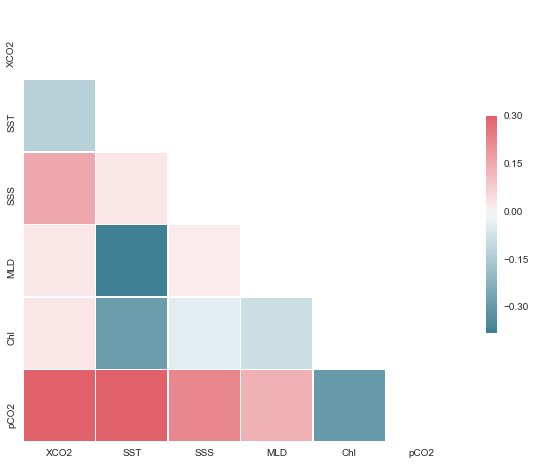

In [14]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig = sns_plot.get_figure()
fig.savefig("corr_matrix.png", dpi=300)

In [ ]:
sns.pairplot(df[df.socat_mask == 1][features])

# Define train and test dataset

In [15]:
df['log_MLD'] = np.log(df['MLD'])
df['log_Chl'] = np.log(df['Chl'])
features = ['XCO2', 'SST', 'SSS', 'log_MLD', 'log_Chl']
X_train = df[df.socat_mask == 1][features]
y_train = df[df.socat_mask == 1]['pCO2']
X_test = df[df.socat_mask == 0][features]
y_test = df[df.socat_mask == 0]['pCO2']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(143943, 5) (143943,)
(8019727, 5) (8019727,)


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
reg = LinearRegression().fit(X_train_scaled, y_train)

In [18]:
reg.score(X_test_scaled, y_test)

0.33027836664773447

In [19]:
y_pred = reg.predict(X_test_scaled)

In [22]:
mean_squared_error(y_test, y_pred) ** .5

26.0590698524916

# Define train and test dataset only using SST and SSS

In [23]:
features = ['SST', 'SSS']
X_train = df[df.socat_mask == 1][features]
y_train = df[df.socat_mask == 1]['pCO2']
X_test = df[df.socat_mask == 0][features]
y_test = df[df.socat_mask == 0]['pCO2']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(143943, 2) (143943,)
(8019727, 2) (8019727,)


# Train and evaluate the model

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
reg = LinearRegression().fit(X_train_scaled, y_train)

In [26]:
reg.score(X_test_scaled, y_test)

0.07480036416512037

# Use only SOCAT locations to train and test data

In [27]:
features = ['XCO2', 'SST', 'SSS', 'log_MLD', 'log_Chl']
X = df[df.socat_mask == 1][features]
y = df[df.socat_mask == 1]['pCO2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [28]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(107957, 5) (107957,)
(35986, 5) (35986,)


In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
reg = LinearRegression().fit(X_train_scaled, y_train)
reg.score(X_test_scaled, y_test)

0.3757616808001202

In [31]:
y_pred = reg.predict(X_test_scaled)

In [32]:
mean_squared_error(y_test, y_pred) ** .5

24.982696139681906